In [9]:
import pandas as pd
import numpy as np
from glob import  glob
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import xarray as xr
from sklearn.cluster import KMeans
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [10]:
target_time = pd.date_range('19910101','20201231',freq='d')
df_times = pd.DataFrame({'index': target_time}, index=target_time)
df_times = df_times.drop(index=df_times[(df_times.index.day==29) & (df_times.index.month==2)].index)

paths = glob('data/raw/*')

def fix_name(d):
    return d.split(':')[-1].replace('\n','')[1:]

In [11]:
n_total_days = len(df_times)
print(f"observações esperadas {n_total_days}")

observações esperadas 10950


In [12]:
dfs = list()
for p in paths:
    
    with open(p) as file:
        data = file.readlines()
        names = ['name', 'cod', 'lat', 'lon', 'alt', 'status', 'init_at', 'end_at', 'freq']
        values = [fix_name(d) for d in data[:9]]
        cfg = dict(zip(names, values))

    df = pd.read_csv(p, sep=';', na_values=['-9999.0','null'], skiprows=9)

    for name, value in cfg.items():
        df[name] = value
    
    df.index = pd.to_datetime(df['Data Medicao'].values)
    df = df.loc['1991-01-01':'2020-12-31']
    df = df.drop(index=df[(df.index.day==29) & (df.index.month==2)].index)
    df = df_times.combine_first(df)

    main_df = df[['TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)']]

    total = len(main_df)
    total_nan = len(main_df) - len(main_df.dropna())
    percent_null = total_nan/total * 100
    
    df['percent_null'] = round(float(percent_null), 1)
    df = df.sort_values('index')

    if percent_null < 21:       

        assert len(df) == n_total_days
        dfs.append(df)  

In [13]:
sel_columns = [
    'Data Medicao', 
    'PRECIPITACAO TOTAL, DIARIO(mm)',
    'TEMPERATURA MAXIMA, DIARIA(°C)',
    'TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)',
    'TEMPERATURA MINIMA, DIARIA(°C)',
    'UMIDADE RELATIVA DO AR, MEDIA DIARIA(%)', 
    'cod', 
    'lat', 
    'lon', 
    'alt',
    'name',
    'percent_null'
]
rename_cols = {
    'Data Medicao':'datas', 
    'PRECIPITACAO TOTAL, DIARIO(mm)':'prec',
    'TEMPERATURA MAXIMA, DIARIA(°C)':'tmax',
    'TEMPERATURA MEDIA COMPENSADA, DIARIA(°C)':'tmean',
    'TEMPERATURA MINIMA, DIARIA(°C)':'tmin',
    'UMIDADE RELATIVA DO AR, MEDIA DIARIA(%)':'ur', 
}
df_concat = pd.concat(dfs)
df_concat = df_concat.loc[:, sel_columns].rename(columns=rename_cols)
df_concat['day_of_year'] = np.nan
df_concat['p95'] = np.nan
df_concat['p90'] = np.nan
df_concat['mean'] = np.nan

In [14]:
codes = df_concat.cod.dropna().unique()
names = [df_concat[df_concat.cod==code].name.iloc[0] for code in codes]
lons = [float(df_concat[df_concat.cod==code].lon.iloc[0]) for code in codes]
lats = [float(df_concat[df_concat.cod==code].lat.iloc[0]) for code in codes]
alt = [float(df_concat[df_concat.cod==code].alt.iloc[0]) for code in codes]
percent_null = [float(df_concat[df_concat.cod==code].percent_null.iloc[0]) for code in codes]
cidades = pd.DataFrame(dict(names=names, lons=lons, lats=lats, alt=alt, percent_null=percent_null), index=codes)

In [20]:
cidades

,names,lons,lats,alt,percent_null
83942,CAXIAS DO SUL,-51.186389,-29.196111,750.16,7.0
83948,TORRES,-49.716667,-29.350278,4.66,7.2
83964,ENCRUZILHADA DO SUL,-52.524722,-30.543056,427.75,4.2
83967,PORTO ALEGRE,-51.174767,-30.053611,41.18,2.7
83980,BAGE,-54.119444,-31.305556,245.66,1.3
83985,PELOTAS,-52.416667,-31.783333,13.00,7.9
83995,RIO GRANDE,-52.167725,-32.078809,4.89,20.1
83997,SANTA VITORIA DO PALMAR,-53.350278,-33.531667,24.01,0.6
83842,CURITIBA,-49.230556,-25.448611,923.50,1.8
83872,INDAIAL,-49.268056,-26.913611,72.28,20.5


In [16]:
assert len(df_concat) == len(cidades) * n_total_days

In [17]:
# correction year_of_day because we ignoring 02/29 when is leapyear
for i in tqdm(range(len(df_concat))):
    
    index = df_concat.index[i]
    assert isinstance(index, pd.Timestamp)
    
    day_of_year = index.day_of_year
    is_leap_year = calendar.isleap(index.year)
    
    if is_leap_year:
        if day_of_year >= 60:
            day_of_year -= 1

    df_concat.loc[index, 'day_of_year'] = int(day_of_year)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 284700/284700 [02:23<00:00, 1984.26it/s]


In [21]:
df_clim = list()
df_done = list()
for code in codes:
    df_sel = df_concat[df_concat.cod==code].copy()

    try:
        assert len(df_sel) == n_total_days
    except:
        df_sel = df_times.combine_first(df_sel)
    
    days = df_sel.day_of_year.dropna().unique()
    _df = pd.DataFrame()
    _df['mean'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).mean()
    _df['p90'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).quantile(0.9)
    _df['p95'] = df_sel.loc[:, 'tmean'].groupby(by=df_sel.day_of_year).quantile(0.95)
    _df['code'] = code

    for day in days:
        df_sel.loc[df_sel.day_of_year==day, 'mean'] = _df.loc[day, 'mean']
        df_sel.loc[df_sel.day_of_year==day, 'p90'] = _df.loc[day, 'p90']
        df_sel.loc[df_sel.day_of_year==day, 'p95'] = _df.loc[day, 'p95']

    assert len(df_sel) == n_total_days
    
    df_done.append(df_sel)
    df_clim.append(_df)
    
df_clim = pd.concat(df_clim).reset_index()
df_done = pd.concat(df_done)

df_done['anom_p95'] = df_done['tmean'] - df_done['p95']
df_done['anom_p90'] = df_done['tmean'] - df_done['p90']
df_done['anom_mean'] = df_done['tmean'] - df_done['mean']

In [22]:
assert len(df_done) == len(cidades) * n_total_days

In [23]:
assert len(df_clim) == len(cidades) * 365

In [24]:
#df_done.loc[(df_done.day_of_year==221) & (df_done.name=='CAXIAS DO SUL')]['tmean'].mean()

In [25]:
#df_done.loc[(df_done.day_of_year==221) & (df_done.name=='CAXIAS DO SUL')]

In [26]:
#df_done[df_done.index.month.isin([6,7,8,9,10])]

In [27]:
def extract(codes, df_done, variable, fill_with_nans=True):
    dfs = list()
    for i, code in tqdm(enumerate(codes)):
        
        df_code = df_done[df_done['cod']==code]
        df_code = df_times.combine_first(df_code)
        
        info = df_code.loc[:, ['name', 'cod', 'lat', 'lon', 'alt']]

        if fill_with_nans:
            df_code[variable] = df_code[variable].fillna(df_code[variable].mean())
        
        #df_final = pd.concat([info, df_code[variable]], axis=1).reset_index()
        
        _df = pd.DataFrame({code:df_code[variable].values}, index=df_code['index']).T
        dfs.append(_df)

    print(df.values.shape)
    print(df.values.ravel().shape)
    
    data2group = pd.DataFrame(
        [
            df.values.ravel() for df in dfs
        ], 
        columns=[str(c).split(' ')[0] for c in _df.columns], 
        index=[str(df.index[0]) for df in dfs]
    )
    
    data = data2group.reset_index()    
    data.index = data['index']
    data = data.drop(columns=['index'])
    return data

In [28]:
# dfs = list()
# for i, code in enumerate(codes):
#     df_code = df_done[df_done['cod']==code]
#     df_code = df_times.combine_first(df_code)
#     info = df_code.loc[:, ['name', 'cod', 'lat', 'lon', 'alt']]
    
#     df_code['anom_mean'] = df_code['anom_mean'].fillna(df_code['anom_mean'].mean())
    
#     df_final = pd.concat([info, df_code['anom_mean']], axis=1).reset_index()
    
#     _df = pd.DataFrame({code:df_final['anom_mean'].values}, index=df_final['index']).T
#     dfs.append(_df)


# data2group = pd.DataFrame([df.values.ravel() for df in dfs], columns=[str(c).split(' ')[0] for c in _df.columns], index=[str(df.index[0]) for df in dfs])
# data2group = data2group.reset_index()
# idx2code = data2group['index'].to_dict()

# data = data2group.iloc[:, :]
# data.index = data['index']
# data = data.drop(columns=['index'])

In [29]:
data = extract(codes, df_done, variable='anom_mean')

26it [00:01, 21.88it/s]


(10950, 22)
(240900,)


In [30]:
assert data.shape[0] == len(cidades)
assert data.shape[1] == n_total_days

In [31]:
data

,1991-01-01,1991-01-02,1991-01-03,1991-01-04,1991-01-05,1991-01-06,1991-01-07,1991-01-08,1991-01-09,1991-01-10,...,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31
index,,,,,,,,,,,,,,,,,,,,,
83942,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,-1.116657e-16,...,-3.217241e+00,-4.137931e-01,1.968966e+00,-1.310345e-01,7.931034e-02,-6.965517e-01,-6.586207e-01,1.128571e+00,3.272414e+00,-6.551724e-01
83948,-1.096667e+00,-4.633333e-01,1.333333e-02,-1.833333e-01,-6.466667e-01,-1.373333e+00,-1.063333e+00,-1.846667e+00,-2.816667e+00,-3.566667e+00,...,-2.313333e+00,-1.200000e-01,1.568966e+00,9.103448e-01,2.310345e-01,6.689655e-01,8.000000e-01,7.862069e-01,1.382759e+00,1.034483e-01
83964,8.517241e-01,1.068966e+00,-1.548276e+00,-3.072414e+00,-2.793103e+00,-9.655172e-01,2.482759e-01,1.386207e+00,1.934483e+00,-2.344828e-01,...,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16,-1.300765e-16
83967,-5.413793e-01,1.579310e+00,-8.206897e-01,-2.727586e+00,-2.713793e+00,-1.768966e+00,-6.068966e-01,2.793103e-01,1.672414e+00,-1.286207e+00,...,-3.048276e+00,-8.862069e-01,1.434483e+00,4.500000e-01,8.666667e-02,-7.000000e-02,5.166667e-01,1.293333e+00,3.020690e+00,-9.344828e-01
83980,1.996667e+00,1.536667e+00,-4.200000e-01,-2.493333e+00,-2.260000e+00,1.800000e-01,2.083333e+00,3.480000e+00,1.226667e+00,6.266667e-01,...,-2.844828e+00,-1.241379e-01,3.093103e+00,1.610345e+00,5.206897e-01,-3.724138e-01,1.072414e+00,1.250000e+00,1.633333e-01,-3.941379e+00
83985,9.034483e-01,1.386207e+00,-1.258621e+00,-2.872414e+00,-2.455172e+00,-1.313793e+00,6.206897e-02,4.965517e-01,1.127586e+00,-5.655172e-01,...,-3.021429e+00,-1.196429e+00,1.303571e+00,2.392857e-01,1.071429e-01,1.028571e+00,2.428571e-01,2.250000e-01,1.903571e+00,-2.270370e+00
83995,4.960000e-01,1.316000e+00,-1.200000e+00,-2.912000e+00,-4.160000e-01,-9.480000e-01,-1.912000e+00,-8.920000e-01,6.666667e-01,-4.560000e-01,...,-6.168751e-17,-6.168751e-17,-6.168751e-17,-6.168751e-17,-6.168751e-17,-6.168751e-17,-6.168751e-17,-6.168751e-17,-6.168751e-17,-6.168751e-17
83997,1.313333e+00,3.000000e-02,-1.876667e+00,-1.846667e+00,-1.940000e+00,-1.676667e+00,-4.133333e-01,6.900000e-01,-2.100000e-01,-3.533333e-01,...,-3.473333e+00,-3.833333e-01,1.153333e+00,1.160000e+00,8.666667e-01,-4.179663e-17,4.100000e-01,1.503333e+00,2.530000e+00,-2.816667e+00
83842,-3.586207e+00,-1.224138e+00,-7.034483e-01,-1.717241e+00,-3.941379e+00,-3.596552e+00,-2.824138e+00,-1.562069e+00,-8.310345e-01,-5.103448e-01,...,-1.827586e+00,-9.000000e-01,-1.936667e+00,-1.806667e+00,-1.493333e+00,-4.227848e-17,1.033333e-01,1.931034e-01,2.575862e+00,8.166667e-01


In [32]:
def fancy_dendrogram(ax, *args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(ax=ax, *args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Dendograma')
        ax.set_xlabel('Estações')
        ax.set_ylabel('Distâncias')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                ax.plot(x, y, 'o', c=c)
                ax.annotate("%.4g" % round(y,0), (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            ax.axhline(y=max_d, c='k')
    return ddata

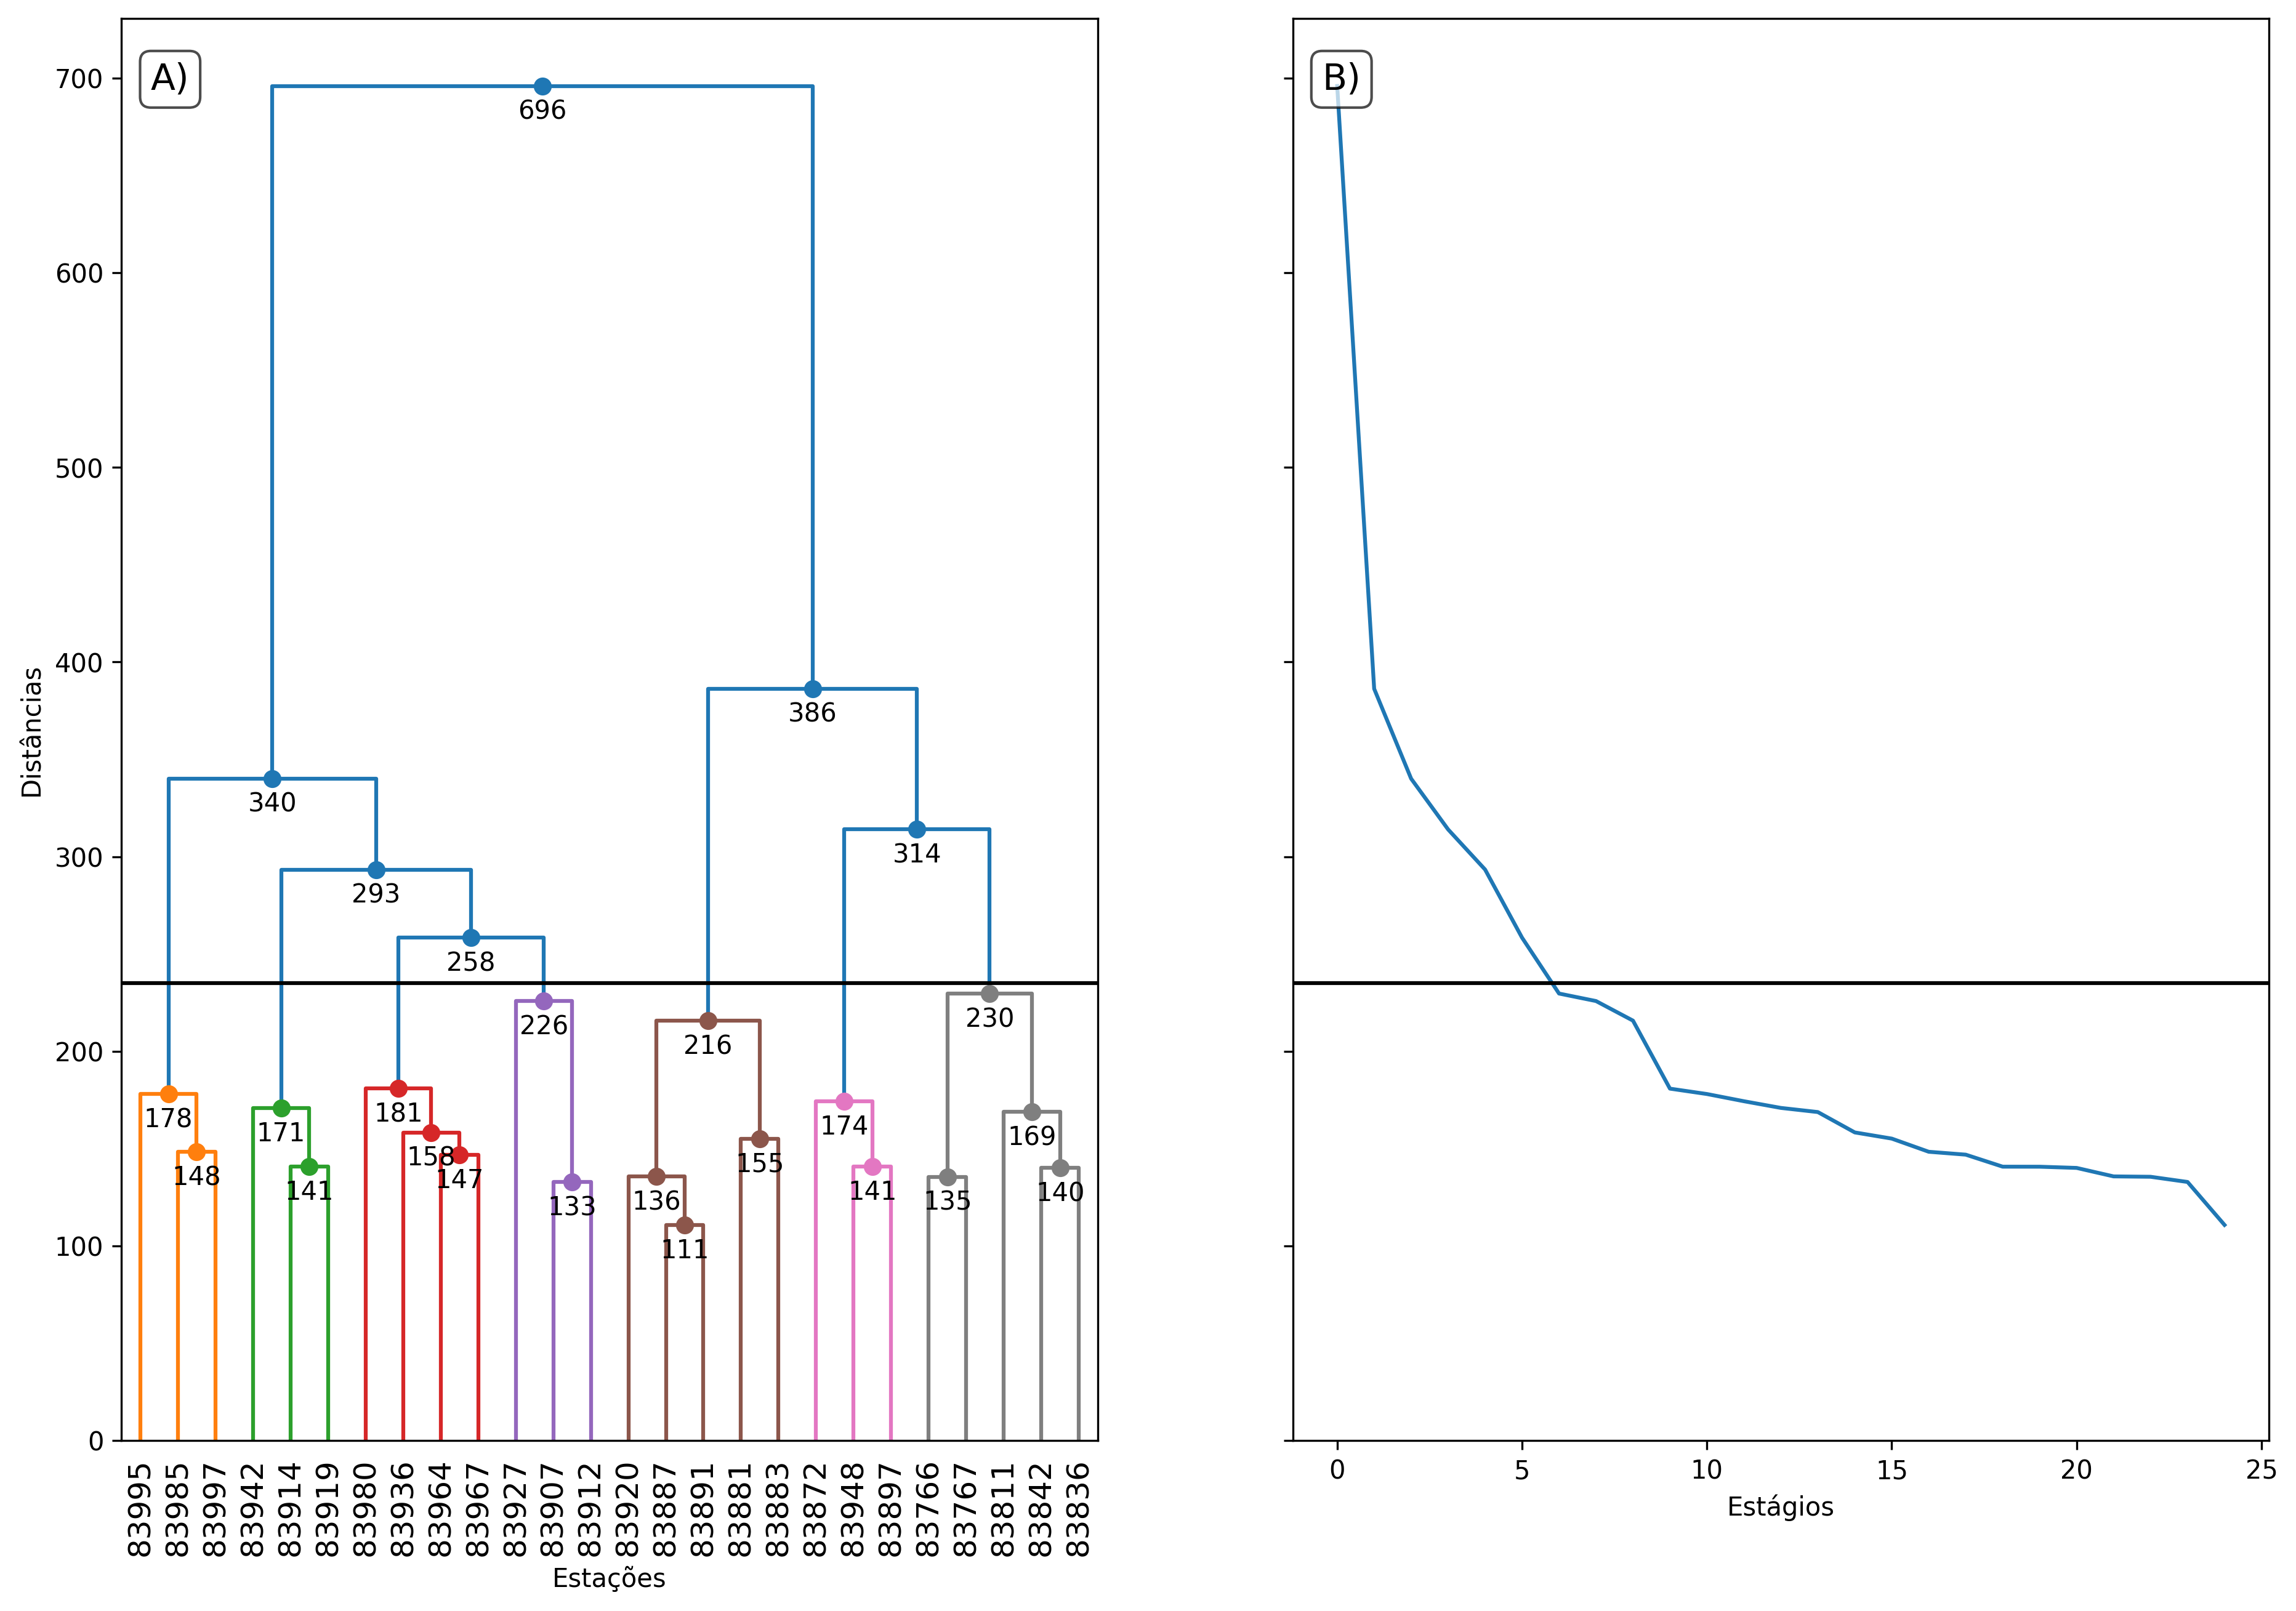

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

labels = list(data.index)
max_d = 235
Z = linkage(pdist(data.values), 'ward')
clusters = fcluster(Z,max_d,criterion='distance')

fig, ax = plt.subplots(1,2, figsize=(15,10), dpi=300, sharey=True)
D = fancy_dendrogram(
    ax[0],
    Z,
    truncate_mode='lastp',
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
    labels=labels,
)

x, y = 0.03, 0.95
for i, letter in enumerate(['A)', 'B)']):
    ax[i].annotate(letter, xy=(x, y), xycoords='axes fraction', color='black', fontsize=14,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    #x += 1.15  # Movendo para baixo para o próximo grupo

last = Z[:,2]
last = last[::-1]
acceleration = np.diff(last, 2)
ax[1].plot(list(range(len(last))), last)
ax[1].axhline(y=max_d, c='k')
ax[1].set_xlabel('Estágios')
#plt.savefig('dendogram_elbow_ward.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [36]:
codes2group = dict(zip(
    D['ivl'], 
    [c.replace('C','G') for c in D['leaves_color_list']]
))
group2color = {'G1': 'orange', 'G2': 'green', 'G3': 'red', 'G4': 'purple', 'G5': 'brown', 'G6': 'pink', 'G7':'gray'}

def get_groups(group):
    return [k for k, v in codes2group.items() if v == group]


groups_ward = data.copy()
groups_ward.insert(0, 'labels', [c.replace('C','G') for c in D['leaves_color_list']])
groups_ward = groups_ward.groupby('labels').mean().T
groups_ward.index = pd.to_datetime(groups_ward.index)

In [35]:
# fig = plt.figure(dpi=500)
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-60, -47, -35, -22], crs=ccrs.PlateCarree())
# ax.add_feature(cfeature.LAND, edgecolor='gray', linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.OCEAN, edgecolor='gray', linewidth=0.5)
# ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

# group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple', 'G5 - Grupo 5': 'brown'}

# x, y = 0.1, 0.9
# for group, color in group_colors.items():
#     ax.annotate(group, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
#                 bbox=dict(facecolor=color, edgecolor=color, boxstyle='round,pad=0.3', alpha=0.7))
#     y -= 0.04  # Movendo para baixo para o próximo grupo

# marker = 'o'
# for code, row in cidades.iterrows():
    
#     color = group2color.get(codes2group.get(code))
        
#     ax.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
#           color=color, s=10, zorder=5, marker=marker)
#     ax.text(row['lons']+0.1, row['lats']+0., str(round(row['alt'],0)) + 'm',
#             transform=ccrs.PlateCarree(),
#             fontsize=4, 
#             color='black', zorder=100,
#             verticalalignment='center')
#     ax.text(row['lons']+0.1, row['lats']+0.5, str(row['percent_null']) + '%',
#             transform=ccrs.PlateCarree(),
#             fontsize=4, 
#             color='black', zorder=100,
#             verticalalignment='center')
#     ax.text(row['lons']+0.1, row['lats']+0.25, code,
#             transform=ccrs.PlateCarree(),
#             fontsize=4,
#             color='black', zorder=100,
#             verticalalignment='center')

# plt.savefig('stations_ward.png')
# plt.show()

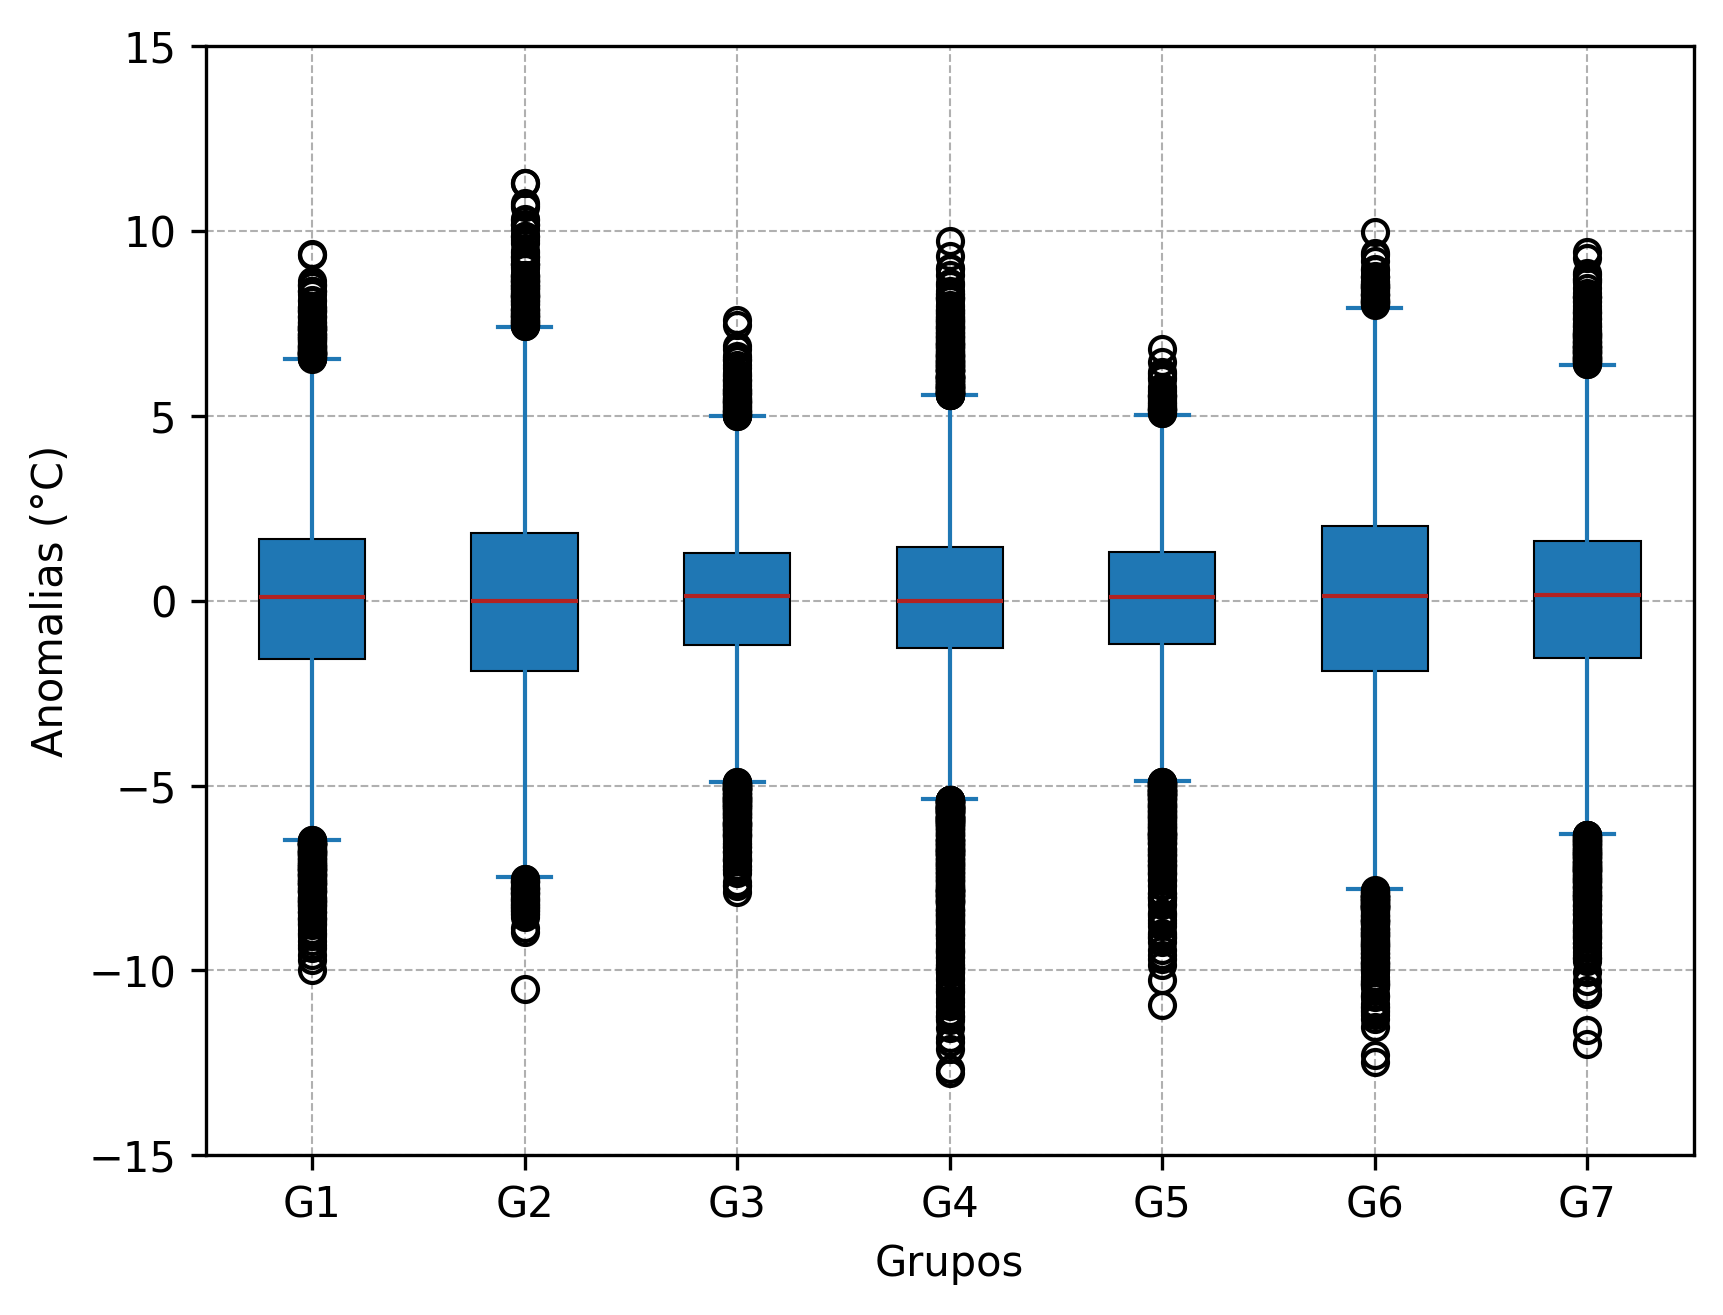

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi=300, sharex=True)
values_ward = groups_ward #.resample('Y').mean()

# Plotando os boxplots com cores diferentes
boxprops = dict(linestyle='-', linewidth=.5, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='firebrick')
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow']

values_ward[['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7']].plot.box(
        ax=ax, 
        subplots=False, 
        sharey=True, 
        sharex=True, 
        boxprops=boxprops, 
        medianprops=medianprops, 
        patch_artist=True
)

for patch, color in zip(ax.artists, colors):
        patch.set_facecolor(color)

ax.set_ylim(-15, 15)
ax.set_xlabel('Grupos')
ax.set_ylabel('Anomalias (°C)', fontsize=10)
#ax.set_title('Média de anomalia trimestral de temperatura')
ax.grid(True, linestyle='--', linewidth=0.5)

#plt.savefig('boxplot_temperature_ward.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [40]:
# Aplicação do KMeans
kmeans = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(data.values)
labels = [f"G{int(l+1)}" for l in kmeans.labels_]
code2group = dict(zip(data.index, labels))

groups_kmeans = data.copy()
groups_kmeans.insert(0, 'labels', labels)
groups_kmeans = groups_kmeans.groupby('labels').mean().T
groups_kmeans.index = pd.to_datetime(groups_kmeans.index)

In [41]:
groups_kmeans

labels,G1,G2,G3,G4,G5,G6,G7
1991-01-01,-1.773385,0.294372,-0.693542,0.904261,-1.235926e+00,0.956753,-1.316667e-01
1991-01-02,-0.482683,0.736667,-0.143168,0.910736,3.658333e-01,1.536236,-4.521386e-17
1991-01-03,-0.210492,0.498148,-1.345712,-1.445096,-5.694444e-02,-0.553908,-4.521386e-17
1991-01-04,-0.931625,-1.623519,-0.277073,-2.543693,-8.851852e-01,-2.754167,-4.521386e-17
1991-01-05,-2.169091,-0.678883,-1.122609,-1.603724,-1.097500e+00,-2.427557,-4.521386e-17
...,...,...,...,...,...,...,...
2020-12-27,0.167241,-0.191667,-0.437346,0.342857,9.962870e-18,-0.120603,-5.566092e-01
2020-12-28,0.225833,-0.653333,0.572222,0.217619,9.962870e-18,0.463103,-8.459770e-01
2020-12-29,0.244828,0.691724,-1.570658,0.576111,9.962870e-18,0.888333,3.426190e-01
2020-12-30,0.989655,0.522040,0.600830,1.477857,9.962870e-18,0.974339,2.819540e+00


In [42]:
# fig = plt.figure(dpi=300)
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-60, -47, -35, -22], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.LAND, edgecolor='gray', linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.OCEAN, edgecolor='gray', linewidth=0.5)
# ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
# x, y = 0.1, 0.9
# for group, color in group_colors.items():
#     ax.annotate(group, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
#                 bbox=dict(facecolor=color, edgecolor=color, boxstyle='round,pad=0.3', alpha=0.7))
#     y -= 0.04  # Movendo para baixo para o próximo grupo


# scatters = []
# for code, row in cidades.iterrows():
#     label = code2group.get(code)
#     color = group2color.get(label)
    
#     scatter = ax.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
#                          color=color, s=10, zorder=5, marker='o')
    
#     ax.text(row['lons']+0.1, row['lats']+0., str(round(row['alt'],3)) + 'm',
#             transform=ccrs.PlateCarree(),
#             fontsize=4, 
#             color='black', zorder=100,
#             verticalalignment='center')
#     ax.text(row['lons']+0.1, row['lats']+0.5, str(row['percent_null']) + '%',
#             transform=ccrs.PlateCarree(),
#             fontsize=4, 
#             color='black', zorder=100,
#             verticalalignment='center')
#     ax.text(row['lons']+0.1, row['lats']+0.25, code,
#             transform=ccrs.PlateCarree(),
#             fontsize=4,
#             color='black', zorder=100,
#             verticalalignment='center')

# # Salvamento e exibição da imagem
# plt.savefig('stations_kmeans.png')
# plt.show()

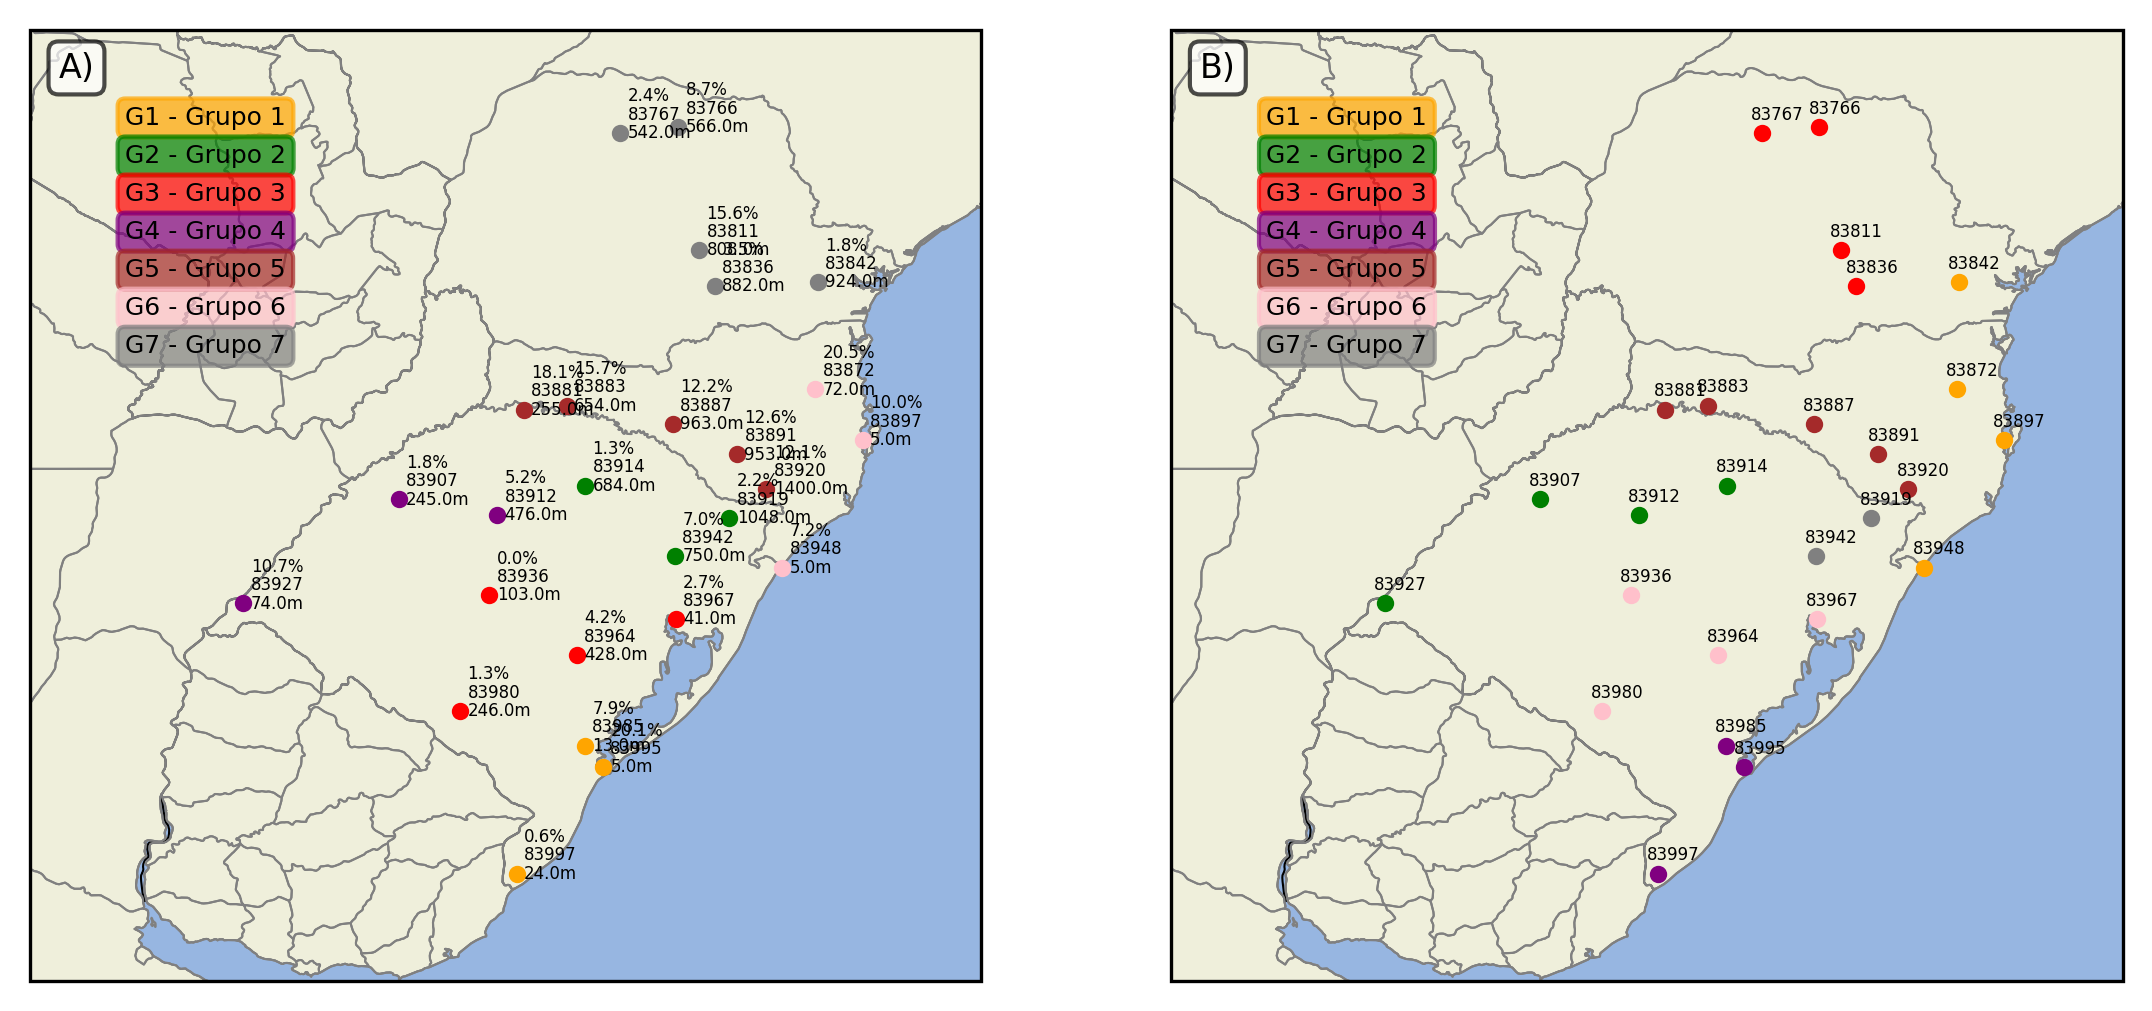

In [62]:
fig = plt.figure(figsize=(9,14), dpi=300)
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax1.set_extent([-60, -47, -35, -22], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND, edgecolor='gray', linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.add_feature(cfeature.OCEAN, edgecolor='gray', linewidth=0.5)
ax1.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

group_colors = {'G1 - Grupo 1': 'orange', 'G2 - Grupo 2': 'green', 'G3 - Grupo 3': 'red', 'G4 - Grupo 4': 'purple', 'G5 - Grupo 5': 'brown',
               'G6 - Grupo 6': 'pink', 'G7 - Grupo 7': 'gray'}

x, y = 0.1, 0.9
for group, color in group_colors.items():
    ax1.annotate(group, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor=color, edgecolor=color, boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.04  # Movendo para baixo para o próximo grupo

marker = 'o'
for code, row in cidades.iterrows():
    
    color = group2color.get(codes2group.get(code))
        
    ax1.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
          color=color, s=10, zorder=5, marker=marker)
    ax1.text(row['lons']+0.1, row['lats']+0., str(round(row['alt'],0)) + 'm',
            transform=ccrs.PlateCarree(),
            fontsize=4, 
            color='black', zorder=100,
            verticalalignment='center')
    ax1.text(row['lons']+0.1, row['lats']+0.5, str(row['percent_null']) + '%',
            transform=ccrs.PlateCarree(),
            fontsize=4, 
            color='black', zorder=100,
            verticalalignment='center')
    ax1.text(row['lons']+0.1, row['lats']+0.25, code,
            transform=ccrs.PlateCarree(),
            fontsize=4,
            color='black', zorder=100,
            verticalalignment='center')
    
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax2.set_extent([-60, -47, -35, -22], crs=ccrs.PlateCarree())

ax2.add_feature(cfeature.LAND, edgecolor='gray', linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.OCEAN, edgecolor='gray', linewidth=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
x, y = 0.1, 0.9
for group, color in group_colors.items():
    ax2.annotate(group, xy=(x, y), xycoords='axes fraction', color='black', fontsize=6,
                bbox=dict(facecolor=color, edgecolor=color, boxstyle='round,pad=0.3', alpha=0.7))
    y -= 0.04  # Movendo para baixo para o próximo grupo


scatters = []
for code, row in cidades.iterrows():
    label = code2group.get(code)
    color = group2color.get(label)
    
    scatter = ax2.scatter(row['lons'], row['lats'], transform=ccrs.PlateCarree(),
                         color=color, s=10, zorder=5, marker='o')
    
    # ax2.text(row['lons']+0.1, row['lats']+0., str(round(row['alt'],3)) + 'm',
    #         transform=ccrs.PlateCarree(),
    #         fontsize=4, 
    #         color='black', zorder=100,
    #         verticalalignment='center')
    # ax2.text(row['lons']-0.15, row['lats']+0.5, str(row['percent_null']) + '%',
    #         transform=ccrs.PlateCarree(),
    #         fontsize=4, 
    #         color='black', zorder=100,
    #         verticalalignment='center')
    ax2.text(row['lons']-0.15, row['lats']+0.25, code,
            transform=ccrs.PlateCarree(),
            fontsize=4,
            color='black', zorder=100,
            verticalalignment='center')

axs = [ax1, ax2]
x, y = 0.03, 0.95
for i, letter in enumerate(['A)', 'B)']):
    axs[i].annotate(letter, xy=(x, y), xycoords='axes fraction', color='black', fontsize=8,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))
    #x += 1.15  # Movendo para baixo para o próximo grupoabs
    
plt.savefig('ward_kmeans.pdf', format='pdf', bbox_inches='tight')
plt.show()

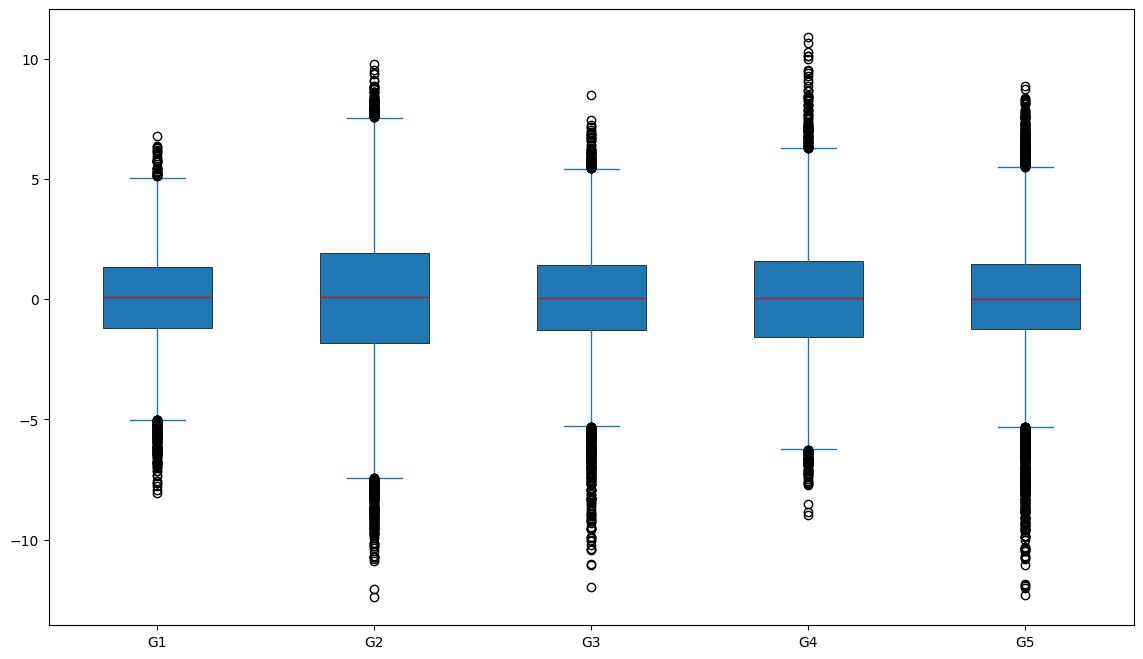

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(14,8), sharex=True, sharey=True)
values_kmeans = groups_kmeans #.resample('ME').mean()

# Plotando os boxplots com cores diferentes
boxprops = dict(linestyle='-', linewidth=.5, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='firebrick')

values_kmeans[['G1', 'G2', 'G3', 'G4', 'G5']].plot.box(
        ax=ax, 
        subplots=False, 
        sharey=True, 
        sharex=True, 
        boxprops=boxprops, 
        medianprops=medianprops, 
        patch_artist=True
)
for patch, color in zip(ax.artists, colors):
    patch.set_facecolor(color)

plt.savefig('boxplot_anom_temperature_kmeans.pdf', format='pdf', bbox_inches='tight')
plt.show()

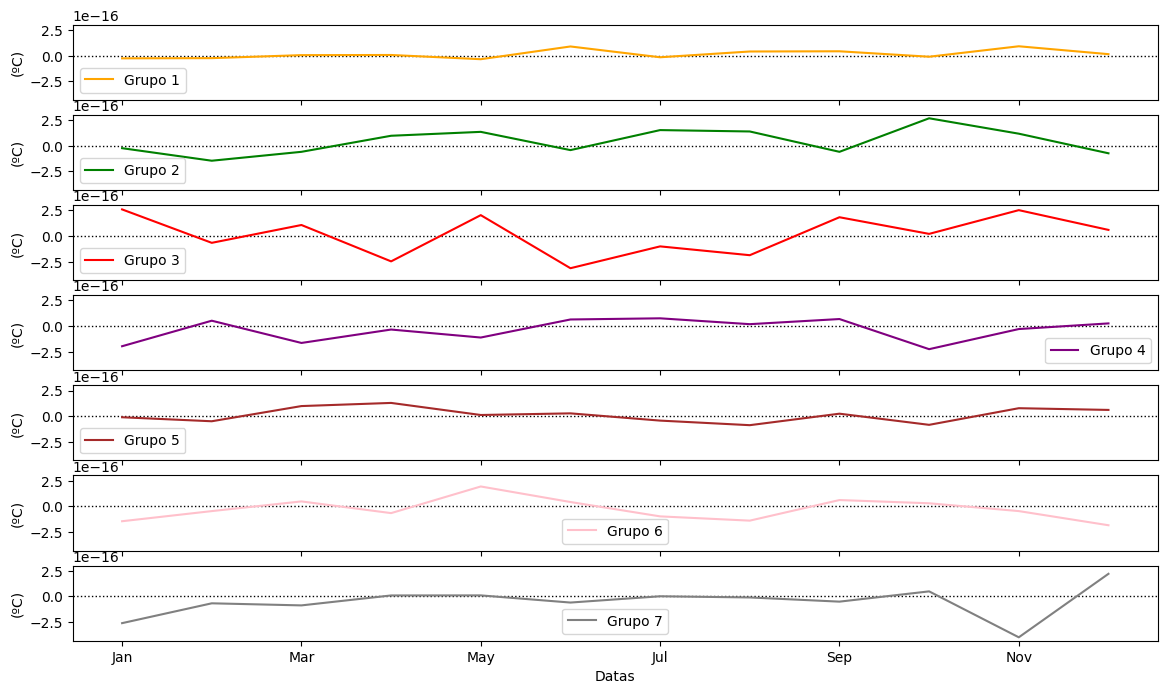

In [51]:
fig, ax = plt.subplots(7,1, figsize=(16,12), sharey=True, sharex=True)
values_kmeans = groups_kmeans.groupby(groups_kmeans.index.month).mean() #.resample('3m').mean()
values_kmeans.index = [datetime(1991,m,1).strftime('%b') for m in values_kmeans.index] 
values_kmeans['G1'].plot(ax=ax[0], alpha=1, subplots=False, figsize=(14,8), ylabel='(ºC)', xlabel='Datas', label='Grupo 1', color=group2color.get('G1'))
values_kmeans['G2'].plot(ax=ax[1], alpha=1, subplots=False, figsize=(14,8), ylabel='(ºC)', xlabel='Datas', label='Grupo 2', color=group2color.get('G2'))
values_kmeans['G3'].plot(ax=ax[2], alpha=1, subplots=False, figsize=(14,8), ylabel='(ºC)', xlabel='Datas', label='Grupo 3', color=group2color.get('G3'))
values_kmeans['G4'].plot(ax=ax[3], alpha=1, subplots=False, figsize=(14,8), ylabel='(ºC)', xlabel='Datas', label='Grupo 4', color=group2color.get('G4'))
values_kmeans['G5'].plot(ax=ax[4], alpha=1, subplots=False, figsize=(14,8), ylabel='(ºC)', xlabel='Datas', label='Grupo 5', color=group2color.get('G5'))
values_kmeans['G6'].plot(ax=ax[5], alpha=1, subplots=False, figsize=(14,8), ylabel='(ºC)', xlabel='Datas', label='Grupo 6', color=group2color.get('G6'))
values_kmeans['G7'].plot(ax=ax[6], alpha=1, subplots=False, figsize=(14,8), ylabel='(ºC)', xlabel='Datas', label='Grupo 7', color=group2color.get('G7'))

ax[0].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
ax[1].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
ax[2].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
ax[3].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
ax[4].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
ax[5].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
ax[6].axhline(lw=1, linestyle='dotted', color='black', zorder=-1)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
plt.savefig('monthly_mean_groups_temperature_kmeans.pdf', format='pdf', bbox_inches='tight')

/tmp/ipykernel_2042772/1987217694.py:5: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  values_kmeans = groups_kmeans.resample('3m').mean()


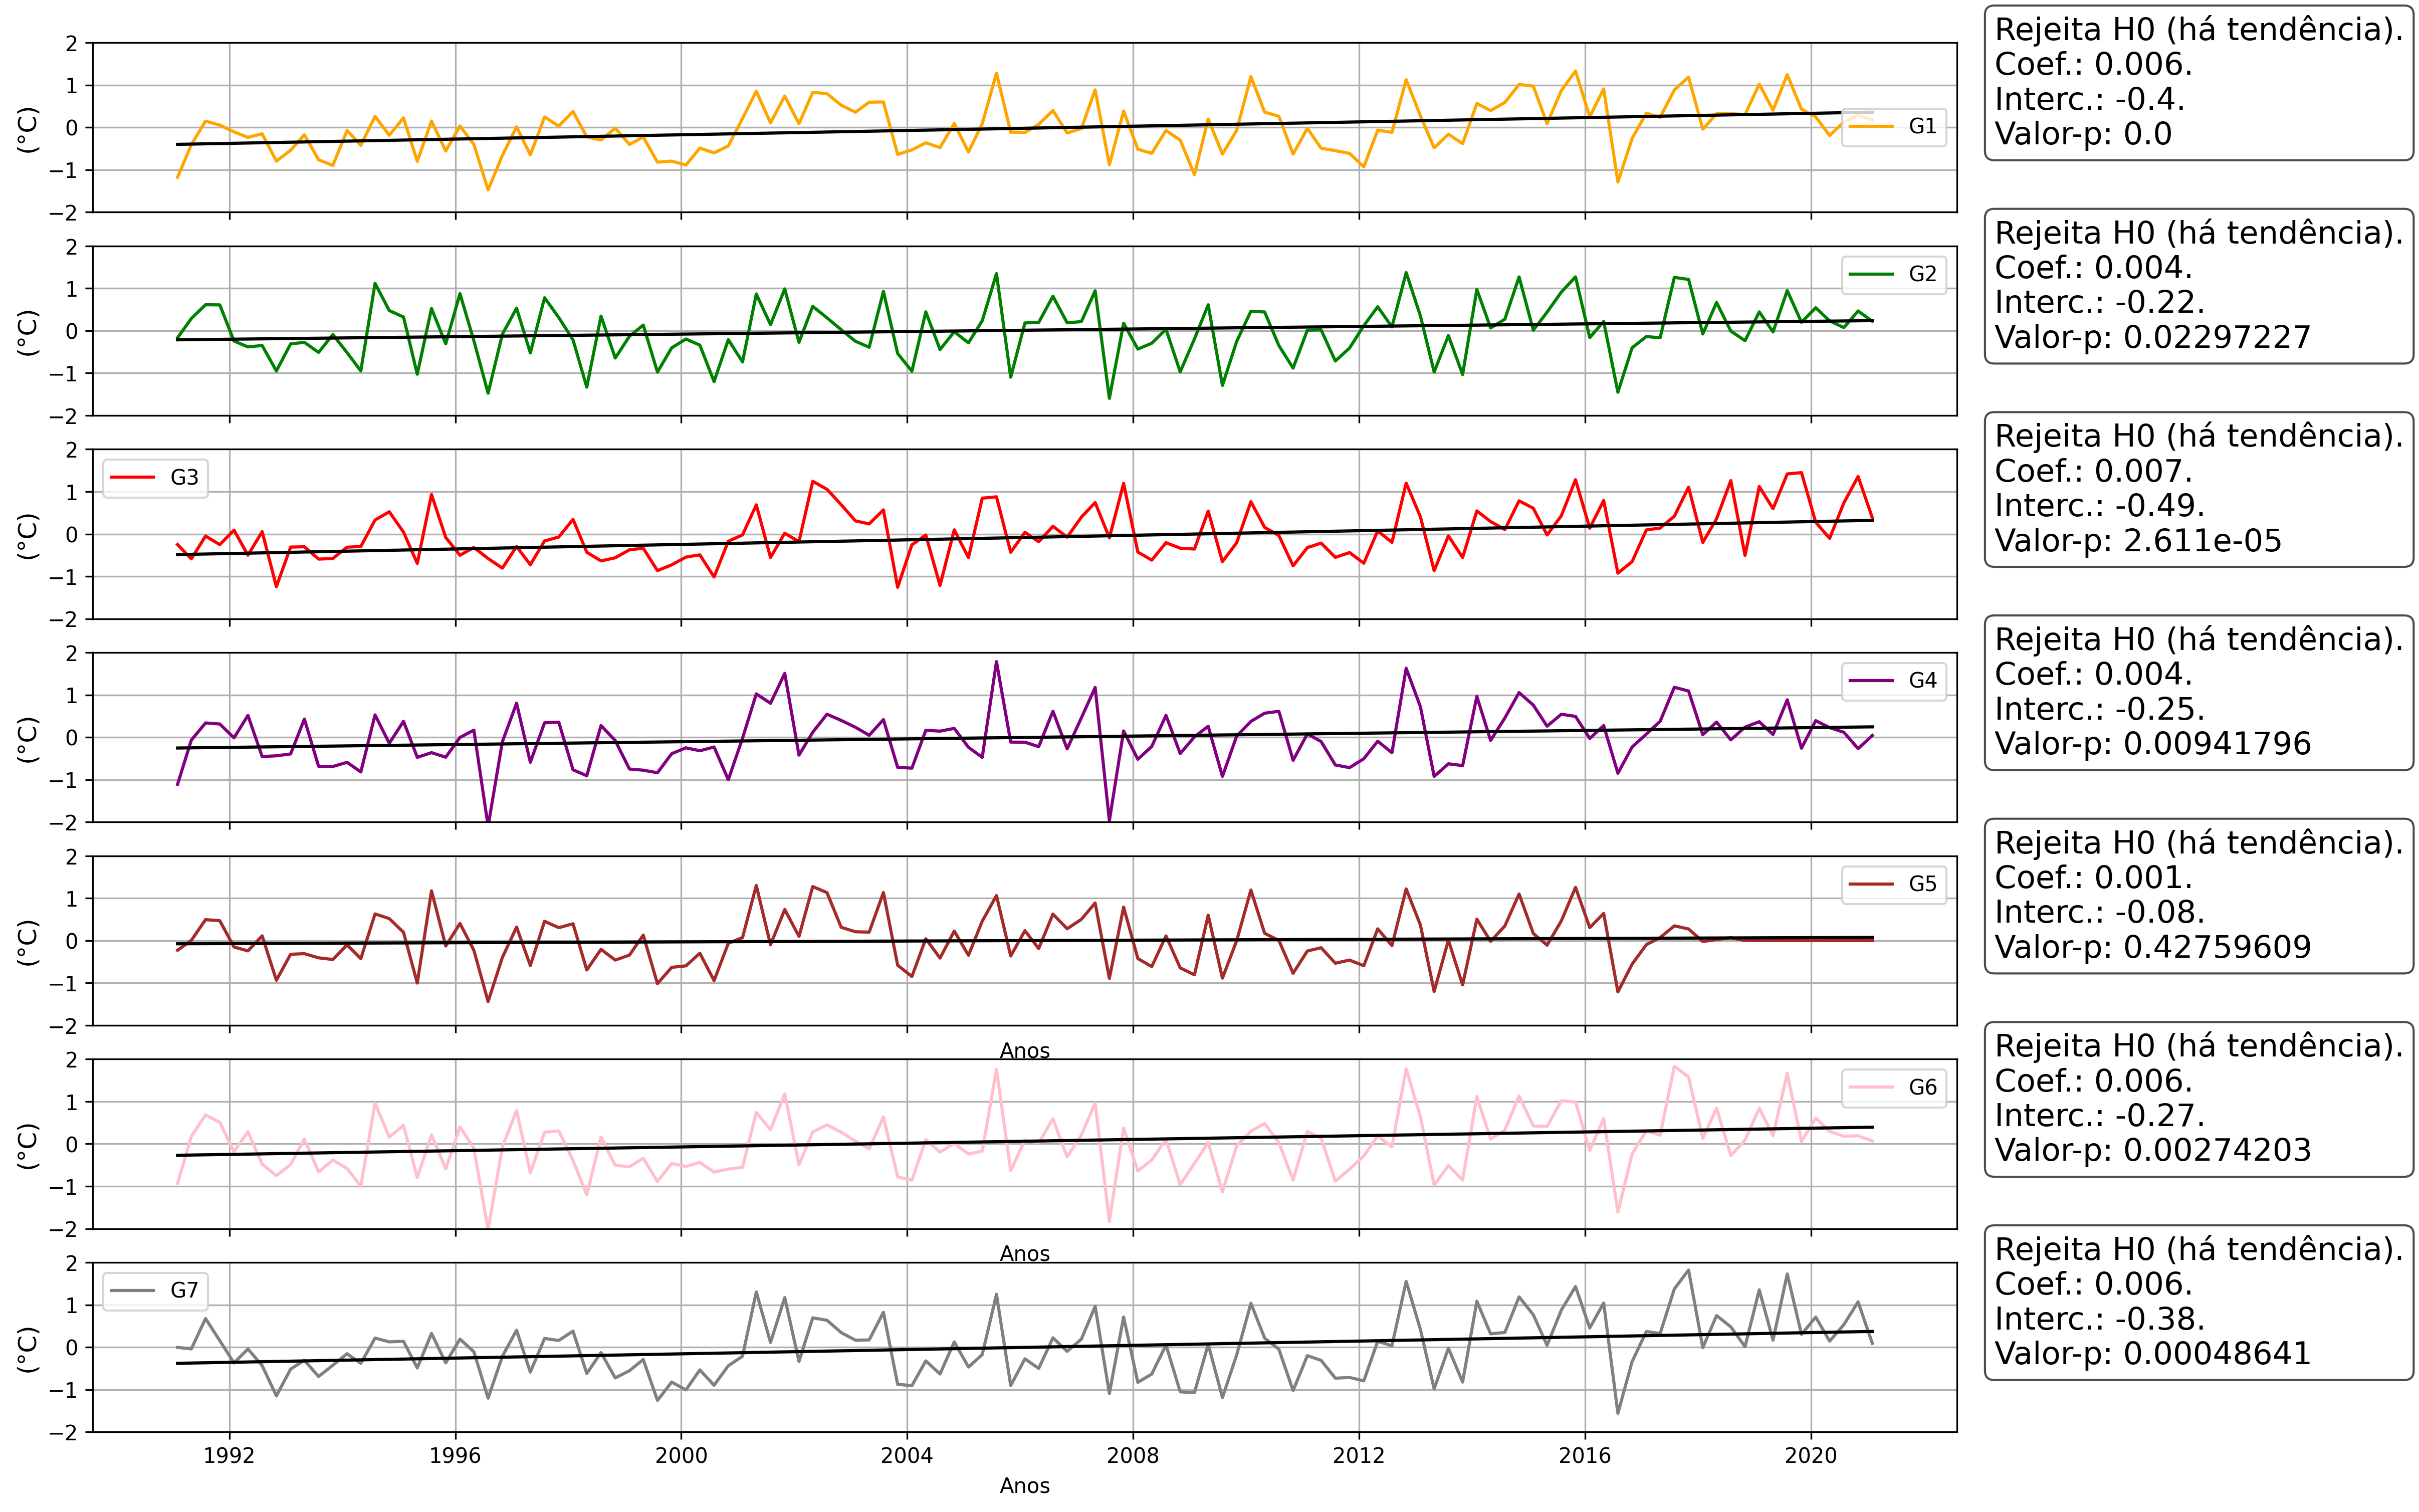

In [53]:
import pymannkendall as mk

fig, ax = plt.subplots(7,1, figsize=(16,12), dpi=300, sharey=True, sharex=True)

values_kmeans = groups_kmeans.resample('3m').mean()

ax[0].plot(values_kmeans.loc[:, 'G1'].index, values_kmeans.loc[:, 'G1'], label='G1', color=group2color.get('G1'))
resultado = mk.original_test(values_kmeans.loc[:, 'G1'], alpha=0.05)
trend_line = np.arange(len(values_kmeans.loc[:, 'G1'])) * resultado.slope + resultado.intercept
ax[0].plot(values_kmeans.loc[:, 'G1'].index, trend_line, color='black')

x, y = 1.02, 0.4
ax[0].annotate(
    f'Rejeita H0 (há tendência).\nCoef.: {round(float(resultado.slope),3)}.\nInterc.: {round(float(resultado.intercept),2)}.\nValor-p: {round(float(resultado.p),4)}', 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[0].set_ylabel('(°C)', fontsize=12)
ax[0].set_ylim(-2,2)
ax[0].grid()
ax[0].legend(loc='right')

ax[1].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G2'], label='G2', color=group2color.get('G2'))
resultado = mk.original_test(values_kmeans.loc[:, 'G2'], alpha=0.05)
trend_line = np.arange(len(values_kmeans.loc[:, 'G2'])) * resultado.slope + resultado.intercept
ax[1].plot(values_kmeans.loc[:, 'G2'].index, trend_line, color='black')

x, y = 1.02, 0.4
ax[1].annotate(
    f'Rejeita H0 (há tendência).\nCoef.: {round(float(resultado.slope),3)}.\nInterc.: {round(float(resultado.intercept),2)}.\nValor-p: {round(float(resultado.p),8)}', 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[1].set_ylabel('(°C)', fontsize=12)
ax[1].set_ylim(-2,2)
ax[1].grid()
ax[1].legend()

ax[2].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G3'], label='G3', color=group2color.get('G3'))
resultado = mk.original_test(values_kmeans.loc[:, 'G3'], alpha=0.05)
trend_line = np.arange(len(values_kmeans.loc[:, 'G3'])) * resultado.slope + resultado.intercept
ax[2].plot(values_kmeans.loc[:, 'G3'].index, trend_line, color='black')

x, y = 1.02, 0.4
ax[2].annotate(
    f'Rejeita H0 (há tendência).\nCoef.: {round(float(resultado.slope),3)}.\nInterc.: {round(float(resultado.intercept),2)}.\nValor-p: {round(float(resultado.p),8)}', 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[2].set_ylabel('(°C)', fontsize=12)
ax[2].set_ylim(-2,2)
ax[2].grid()
ax[2].legend()

ax[3].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G4'], label='G4', color=group2color.get('G4'))
resultado = mk.original_test(values_kmeans.loc[:, 'G4'], alpha=0.05)
trend_line = np.arange(len(values_kmeans.loc[:, 'G4'])) * resultado.slope + resultado.intercept
ax[3].plot(values_kmeans.loc[:, 'G4'].index, trend_line, color='black')

x, y = 1.02, 0.4
ax[3].annotate(
    f'Rejeita H0 (há tendência).\nCoef.: {round(float(resultado.slope),3)}.\nInterc.: {round(float(resultado.intercept),2)}.\nValor-p: {round(float(resultado.p),8)}', 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[3].set_ylabel('(°C)', fontsize=12)
ax[3].set_ylim(-2,2)
ax[3].grid()
ax[3].legend()

ax[4].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G5'], label='G5', color=group2color.get('G5'))
resultado = mk.original_test(values_kmeans.loc[:, 'G5'], alpha=0.05)
trend_line = np.arange(len(values_kmeans.loc[:, 'G5'])) * resultado.slope + resultado.intercept
ax[4].plot(values_kmeans.loc[:, 'G5'].index, trend_line, color='black')

x, y = 1.02, 0.4
ax[4].annotate(
    f'Rejeita H0 (há tendência).\nCoef.: {round(float(resultado.slope),3)}.\nInterc.: {round(float(resultado.intercept),2)}.\nValor-p: {round(float(resultado.p),8)}', 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[4].set_ylabel('(°C)', fontsize=12)
ax[4].set_xlabel('Anos')
ax[4].set_ylim(-2,2)
ax[4].grid()
ax[4].legend()


ax[5].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G6'], label='G6', color=group2color.get('G6'))
resultado = mk.original_test(values_kmeans.loc[:, 'G6'], alpha=0.05)
trend_line = np.arange(len(values_kmeans.loc[:, 'G6'])) * resultado.slope + resultado.intercept
ax[5].plot(values_kmeans.loc[:, 'G6'].index, trend_line, color='black')

x, y = 1.02, 0.4
ax[5].annotate(
    f'Rejeita H0 (há tendência).\nCoef.: {round(float(resultado.slope),3)}.\nInterc.: {round(float(resultado.intercept),2)}.\nValor-p: {round(float(resultado.p),8)}', 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[5].set_ylabel('(°C)', fontsize=12)
ax[5].set_xlabel('Anos')
ax[5].set_ylim(-2,2)
ax[5].grid()
ax[5].legend()


ax[6].plot(values_kmeans.iloc[:, :].index, values_kmeans.loc[:, 'G7'], label='G7', color=group2color.get('G7'))
resultado = mk.original_test(values_kmeans.loc[:, 'G7'], alpha=0.05)
trend_line = np.arange(len(values_kmeans.loc[:, 'G7'])) * resultado.slope + resultado.intercept
ax[6].plot(values_kmeans.loc[:, 'G7'].index, trend_line, color='black')

x, y = 1.02, 0.4
ax[6].annotate(
    f'Rejeita H0 (há tendência).\nCoef.: {round(float(resultado.slope),3)}.\nInterc.: {round(float(resultado.intercept),2)}.\nValor-p: {round(float(resultado.p),8)}', 
    xy=(x, y), xycoords='axes fraction', color='black', fontsize=15,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.7))

ax[6].set_ylabel('(°C)', fontsize=12)
ax[6].set_xlabel('Anos')
ax[6].set_ylim(-2,2)
ax[6].grid()
ax[6].legend()

plt.savefig('tendencia_anomalias_grupos.pdf', format='pdf', bbox_inches='tight')


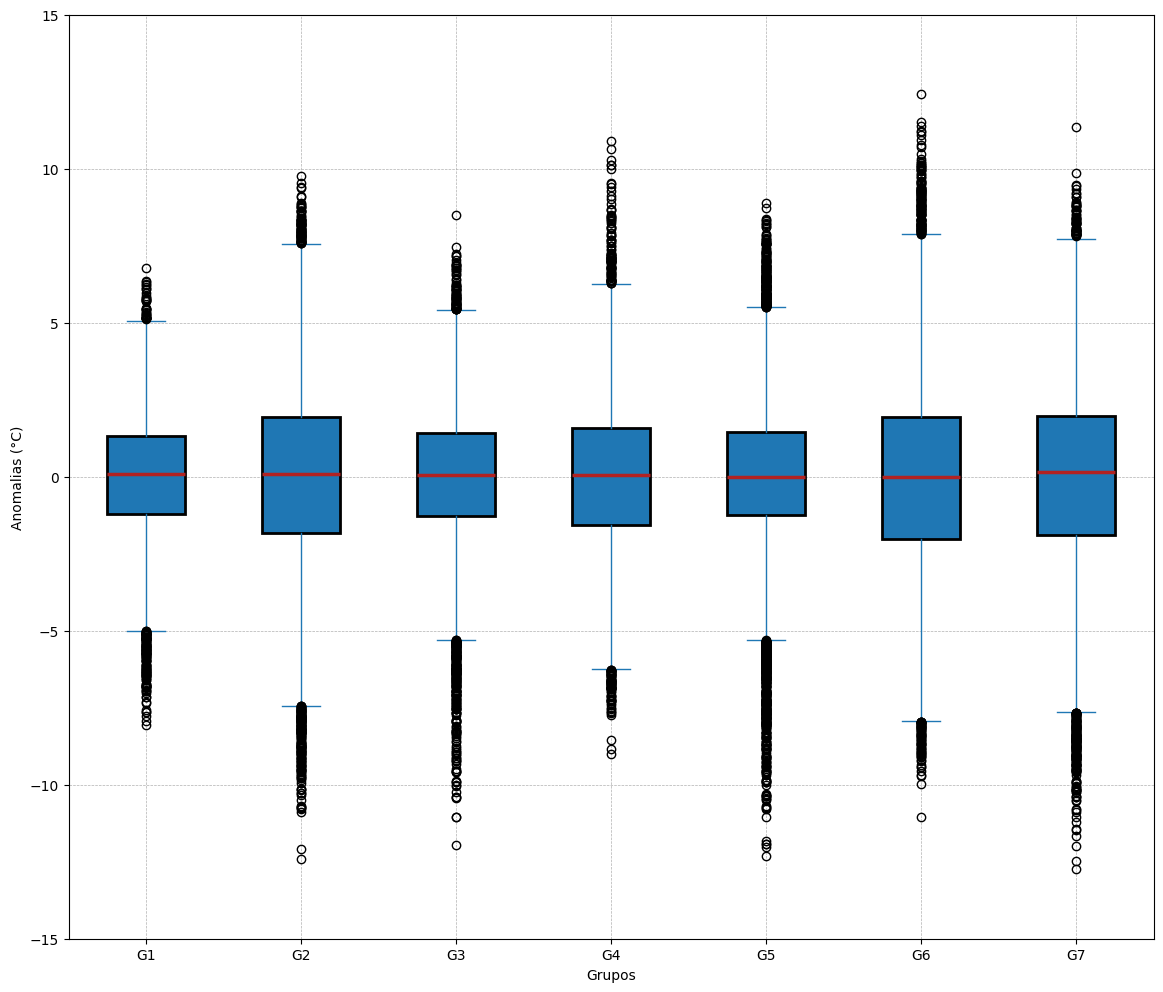

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(14, 12), sharex=True)


# Plotando os boxplots com cores diferentes
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=2.5, color='firebrick')
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow']

groups_kmeans[['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7']].plot.box(
        ax=ax, 
        subplots=False, 
        sharey=True, 
        sharex=True, 
        boxprops=boxprops, 
        medianprops=medianprops, 
        patch_artist=True
)

for patch, color in zip(ax.artists, colors):
        patch.set_facecolor(color)

ax.set_ylim(-15, 15)
ax.set_xlabel('Grupos')
ax.set_ylabel('Anomalias (°C)', fontsize=10)
#ax.set_title('Média de anomalia trimestral de temperatura')
ax.grid(True, linestyle='--', linewidth=0.5)

#plt.savefig('groups_temperature_seasonal_kmeans.png')
plt.show()

In [ ]:
anom_mean = extract(codes, df_done, variable='anom_mean', fill_with_nans=False)
tmean = extract(codes, df_done, variable='tmean', fill_with_nans=False)
mean = extract(codes, df_done, variable='mean', fill_with_nans=False)

teste = tmean.loc['83936'] - mean.loc['83936'] == anom_mean.loc['83936'].values

In [ ]:
tmean

In [ ]:
564/10386 * 100

In [ ]:
teste[teste==True]

In [ ]:
teste[teste==False]

In [ ]:
tmean.loc['83912','1993-08-19']

In [ ]:
tmean.loc['83912','1991-01-01']

In [ ]:
assert tmean.loc['83912','1991-01-01'] - mean.loc['83912','1991-01-01']  == anom_mean.loc['83912','1991-01-01']

In [ ]:
tmean_groups = pd.DataFrame({'G1':tmean.T[get_groups('G1')].mean(axis=1), 
                             'G2':tmean.T[get_groups('G2')].mean(axis=1), 
                             'G3':tmean.T[get_groups('G3')].mean(axis=1), 
                             'G4':tmean.T[get_groups('G4')].mean(axis=1)})

mean_groups = pd.DataFrame({'G1':mean.T[get_groups('G1')].mean(axis=1), 
                             'G2':mean.T[get_groups('G2')].mean(axis=1), 
                             'G3':mean.T[get_groups('G3')].mean(axis=1), 
                             'G4':mean.T[get_groups('G4')].mean(axis=1)})

anom_mean_groups = pd.DataFrame({'G1':anom_mean.T[get_groups('G1')].mean(axis=1), 
                             'G2':anom_mean.T[get_groups('G2')].mean(axis=1), 
                             'G3':anom_mean.T[get_groups('G3')].mean(axis=1), 
                             'G4':anom_mean.T[get_groups('G4')].mean(axis=1)})

In [ ]:
anom_mean_groups

In [ ]:
get_groups('G1')

In [ ]:
tmean

In [ ]:
tmean_groups

In [ ]:
tmean_groups.to_csv('data/pos/tmean_groups_kmeans.csv')

In [ ]:
mean_groups.to_csv('data/pos/tmean_clim_groups_kmeans.csv')

In [ ]:
anom_mean_groups.to_csv('data/pos/tmean_anomaly_groups_kmeans.csv')

In [ ]:
test[test.values==True]

In [ ]:
tmean.loc['83948', '1991-03-24']

In [ ]:
tmean.loc['83948', '1991-03-24']

In [ ]:
anom_mean.loc['83948', '1991-03-24']

In [ ]:
19.62153755290875 - 22.96